In [79]:
from matplotlib import pyplot as plt
import numpy as np
import mido as md
import os
import pandas as pd
from datetime import datetime


## Preprocessing of the data

In [80]:
def midiTrackToNoteSequence(track, timeSignature, mid):
    sequence = []
    notes = {}
    prevTime = 0.0
    for msg in track:
        if msg.is_meta:
            if msg.type == "time_signature":
                timeSignature["numerator"] = msg.numerator
                timeSignature["denominator"] = msg.denominator
            elif msg.type == "set_tempo":
                usPerQuarter = msg.tempo
                sPerQuarter = usPerQuarter / 1e6
                timeSignature["tempo"] = 60 / sPerQuarter * \
                    timeSignature["denominator"] /4
        else:
            time = msg.time / mid.ticks_per_beat * \
                60 / timeSignature["tempo"] + \
                prevTime
            
            if msg.type == "note_on" or msg.type =="note_off":

                note = {
                    "channel": msg.channel,
                    "note": msg.note,
                    "velocity": msg.velocity,
                    "time": time,
                    "end": -1
                }
                key = "{:02}_{:03}".format(msg.channel, msg.note)

                if msg.type == "note_on":
                    if not key in notes:
                        notes[key] = []
                    else: 
                        prevNote = notes[key][-1]

                        if prevNote["end"] < 0:
                            prevNote["end"] = time

                    notes[key].append(note)
                else:
                    if key in notes:
                        prevNote = notes[key][-1]

                        prevNote["end"] = time

            prevTime = time

    for key in notes.keys():
        for note in notes[key]:
            noteLength = 1.0

            if note["end"] >= 0.0:
                noteLength = note["end"] - note["time"]

            sequence.append({
                "time": note["time"],
                "number": note["note"],
                "length": noteLength
            })

    sequence.sort(key = lambda note: note["time"])

    return sequence

def findTrackName(track):
    for msg in track:
        if msg.type == "track_name":
            return msg.name
    return None

def printTrackNames(midiFilename):
    mid = md.MidiFile(midiFilename)

    print("Tracks in {}:".format(midiFilename))

    for track in mid.tracks:
        print("\t{}".format(findTrackName(track)))

def readMidiFileIntoPointSet(filename, trackName = None, singleNote = False):
    mid = md.MidiFile(filename)

    timeSignature = {
        "numerator": 4,
        "denominator": 4,
        "tempo": 60
    }

    noteTimes = []
    noteNumbers = []
    noteLengths = []

    sequence = []

    for track in mid.tracks:
        if trackName:
            currentName = findTrackName(track)

            if currentName != trackName:
                continue

        sequence.extend(midiTrackToNoteSequence(track, timeSignature, mid))

    sequence.sort(key = lambda note: note["time"])

    SMALL_DT = 0.01

    for note in sequence:
        if singleNote and len(noteTimes) > 0:
            if note["time"] - noteTimes[-1] < SMALL_DT:
                continue

        
        noteTimes.append(note["time"])
        noteNumbers.append(note["number"])
        noteLengths.append(note["length"])

    return {
        "t": np.array(noteTimes),
        "n": np.array(noteNumbers),
        "l": np.array(noteLengths),
        "timeSignature": timeSignature
    }

def get_midi_duration(midi_data):
    return midi_data["t"][-1]  #Assuming the last time value represents the total duration

def segment_midi(midi_data, segment_length):
    segments = []
    start_time = 0
    while start_time < midi_data["t"][-1]:
        end_time = start_time + segment_length
        segment_indices = np.where((midi_data["t"] >= start_time) & (midi_data["t"] < end_time))
        segment = {
            "t": midi_data["t"][segment_indices] - start_time,
            "n": midi_data["n"][segment_indices],
            "l": midi_data["l"][segment_indices],
            "timeSignature": midi_data["timeSignature"]
        }
        segments.append(segment)
        start_time += segment_length
    return segments


## Save results

In [81]:
def save_to_excel(key_A_values, PTD_values, normalised_PTD):
    """Saves the results to an Excel file."""

    results_folder = "results"
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    current_time_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{results_folder}/PTD_results_{current_time_str}.xlsx"

    df = pd.DataFrame({
        "Key_A": key_A_values,
        "PTD": PTD_values,
        "Normalised PTD": normalised_PTD,
        "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    })
    
    df.to_excel(filename, index=False)


## Normalisation of score

In [82]:
def consistent_normalize_score(score, scale_max=10000):
    #Ensure the estimated maximum score is not zero to avoid division by zero
    if scale_max == 0:
        return 0  # Optionally adjust based on your context
    #Normalize the score
    normalized_score = (score / scale_max) * 100
    #Ensure the normalized score does not exceed 100
    normalized_score = min(normalized_score, 100)
    normalized_score = max(normalized_score, 0)
    
    return normalized_score

## Algorithm development and experimentation

In [83]:
def proportionalTransportationDistance(set_A, set_B):
    w = set_A["l"] #note weights
    u = set_B["l"]

    W = w.sum()
    U = u.sum()

    t1 = (set_A["t"] - set_A["t"].min()) / (set_A["t"].max() - set_A["t"].min())
    t2 = (set_B["t"] - set_B["t"].min()) / (set_B["t"].max() - set_B["t"].min())
    p1 = set_A["n"] - (set_A["n"] * w/W).sum()
    p2 = set_B["n"] - (set_B["n"] * u/U).sum()

    f = w.reshape(-1, 1) * u.reshape(1, -1)/U
    d = np.sqrt(
        9 * (t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 +
        (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2
    )
    return (f*d).sum() / W

def modifiedPTD(set_A, set_B):
    w = set_A["l"] / set_A["l"].sum()
    u = set_B["l"] / set_B["l"].sum()

    t1 = (set_A["t"] - set_A["t"].min()) / (set_A["t"].max() - set_A["t"].min())
    t2 = (set_B["t"] - set_B["t"].min()) / (set_B["t"].max() - set_B["t"].min())
    p1 = set_A["n"] - (set_A["n"] * w).sum()
    p2 = set_B["n"] - (set_B["n"] * u).sum()

    f = w.reshape(-1, 1) * u.reshape(1, -1)
    d = np.sqrt(
        (t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 +
        (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2
    )

    dargmin0 = d.argmin(axis=0)
    dargmin1 = d.argmin(axis=1)

    dmin0 = d[dargmin0, :]
    dmin1 = d[:, dargmin1]
    fmin0 = f[dargmin0, :]
    fmin1 = f[:, dargmin1]

    return (fmin0 * dmin0).sum() + (fmin1 * dmin1).sum()


#Function to safely normalize time to avoid division by zero
def safe_normalize_time(t):
    if t.size == 0:  #Check if the array is empty
        return t  #Return the empty array directly 
    min_t = t.min()
    max_t = t.max()
    if min_t == max_t:
        return np.zeros_like(t)
    else:
        return (t - min_t) / (max_t - min_t)


#modifiedPTDv1 function with safe normalization
def modifiedPTDv1(set_A, set_B):
    #safe_normalize_time function for time normalization to prevent div by 0 error
    t1 = safe_normalize_time(set_A["t"])
    t2 = safe_normalize_time(set_B["t"])
    
    p1 = set_A["n"]
    p2 = set_B["n"]

    #Continue with length normalization and distance calculation as before
    l1 = set_A["l"] / np.max(set_A["l"])  #Normalize lengths in set_A
    l2 = set_B["l"] / np.max(set_B["l"])  #Normalize lengths in set_B

    d_base = np.sqrt((t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 + (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2)
    
    d_length = np.abs(l1.reshape(-1, 1) - l2.reshape(1, -1))
    d_combined = d_base + d_length
    total_distance = np.min(d_combined, axis=0).sum() + np.min(d_combined, axis=1).sum()

    return total_distance

## Calculating scores and displaying of results

PTD(appass_1.mid, SubMidi) = 245.06264683116024
PTD(appass_2.mid, SubMidi) = 319.74850755999597
PTD(appass_3.mid, SubMidi) = 299.7891645314634
PTD(beethoven_hammerklavier_1.mid, SubMidi) = 296.69734023075466
PTD(beethoven_hammerklavier_2.mid, SubMidi) = 299.07001916505243
PTD(beethoven_hammerklavier_3.mid, SubMidi) = 328.6778724168786
PTD(beethoven_hammerklavier_4.mid, SubMidi) = 233.42651580913986
PTD(beethoven_les_adieux_1.mid, SubMidi) = 332.00950788772184
PTD(beethoven_les_adieux_2.mid, SubMidi) = 665.6962618004744
PTD(beethoven_les_adieux_3.mid, SubMidi) = 339.8330537954145
PTD(beethoven_opus10_1.mid, SubMidi) = 239.1474134158678
PTD(beethoven_opus10_2.mid, SubMidi) = 607.256083633739
PTD(beethoven_opus10_3.mid, SubMidi) = 190.92651156388004
PTD(beethoven_opus22_1.mid, SubMidi) = 270.1801376249703
PTD(beethoven_opus22_2.mid, SubMidi) = 343.5840902448606
PTD(beethoven_opus22_3.mid, SubMidi) = 339.338445621891
PTD(beethoven_opus22_4.mid, SubMidi) = 313.154367963519
PTD(beethoven_opu

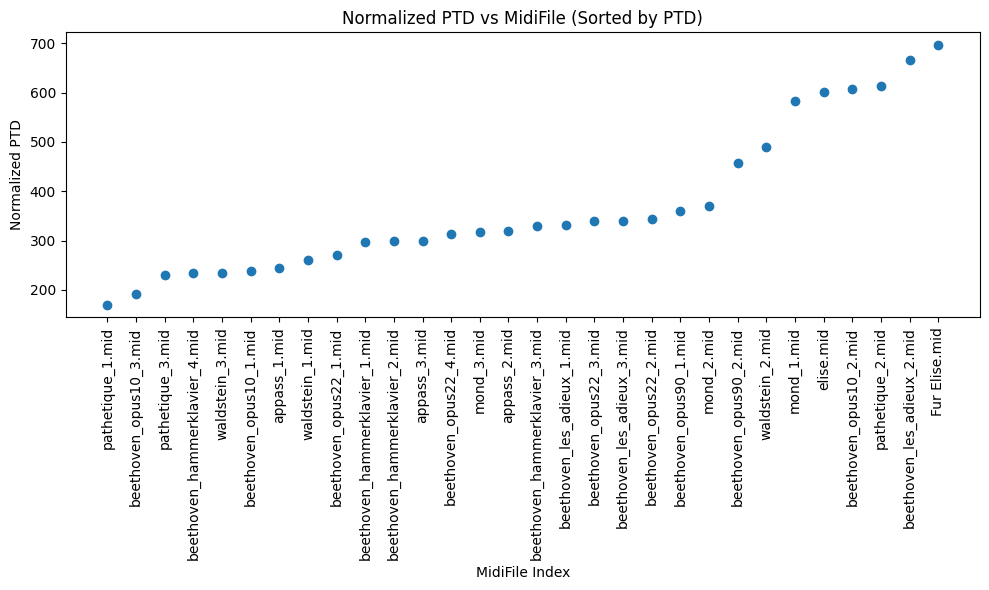

Minimum Score (Should Always be Subject MIDI): pathetique_1.mid: 170.51687739590832
2nd Minimum Score: beethoven_opus10_3.mid: 190.92651156388004


In [84]:


subMidi_folder_path = "SubjectMidiFile"
folder_path = "MIDITestDb"
subMidi_name = "SubMidi"
sets = {}


#Define the get_midi_duration function
def get_midi_duration(midi_data):
    return midi_data["t"][-1]

#Define the segment_midi function
def segment_midi(midi_data, segment_length):
    segments = []
    start_time = 0
    while start_time < midi_data["t"][-1]:
        end_time = start_time + segment_length
        segment_indices = np.where((midi_data["t"] >= start_time) & (midi_data["t"] < end_time))[0]
        segment = {
            "t": midi_data["t"][segment_indices] - start_time,
            "n": midi_data["n"][segment_indices],
            "l": midi_data["l"][segment_indices],
            "timeSignature": midi_data["timeSignature"]
        }
        segments.append(segment)
        start_time += segment_length
    return segments

#Load the subject MIDI file
for sub_file_name in os.listdir(subMidi_folder_path):
    if sub_file_name.endswith((".mid", ".midi")):
        file_path = os.path.join(subMidi_folder_path, sub_file_name)
        SubjectMidi = readMidiFileIntoPointSet(file_path)
        subject_midi_data = SubjectMidi
        sets[subMidi_name] = SubjectMidi
        break  #Process only the first MIDI file as the subject MIDI

subject_duration = get_midi_duration(subject_midi_data)

#Process and compare MIDI files in the dataset folder
for file_name in os.listdir(folder_path):
    if file_name.endswith((".mid", ".midi")):
        file_path = os.path.join(folder_path, file_name)
        midi_data = readMidiFileIntoPointSet(file_path)
        sets[file_name] = midi_data

min_score = float('inf')
second_min_score = float('inf')
min_score_file = ""
second_min_score_file = ""

key_A_values = []
PTD_values = []
Normalized_PTD_values = []

#Compare each MIDI file to the subject MIDI file
for key_A, midi_data_A in sets.items():
    if key_A == subMidi_name:
        continue  #Skip comparing the subject MIDI file to itself

    midi_duration_A = get_midi_duration(midi_data_A)
    if midi_duration_A > subject_duration:
        segments = segment_midi(midi_data_A, subject_duration)
        distances = [modifiedPTDv1(segment, subject_midi_data) for segment in segments]
        PTD = min(distances) #set PTD to smallest score

    else:
        PTD = modifiedPTDv1(midi_data_A, subject_midi_data)

    print("PTD({}, {}) = {}".format(key_A, subMidi_name, PTD))

    if PTD < min_score:
        second_min_score, min_score = min_score, PTD
        second_min_score_file, min_score_file = min_score_file, key_A
    elif PTD < second_min_score:
        second_min_score = PTD
        second_min_score_file = key_A

    Normalized_PTD = PTD  #Placeholder for normalization logic
    Normalized_PTD_values.append(Normalized_PTD)
    key_A_values.append(key_A)
    PTD_values.append(PTD)

    #save results to an Excel file
    save_to_excel(key_A_values, PTD_values, Normalized_PTD_values)

#Plot the results
plotData = list(zip(key_A_values, Normalized_PTD_values))
sorted_data = sorted(plotData, key=lambda x: x[1])
sorted_key_A_values, sorted_PTD_values = zip(*sorted_data)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(range(len(sorted_key_A_values)), sorted_PTD_values)
ax.set_xlabel('MidiFile Index')
ax.set_ylabel('Normalized PTD')
ax.set_title('Normalized PTD vs MidiFile (Sorted by PTD)')
ax.set_xticks(range(len(sorted_key_A_values)))
ax.set_xticklabels(sorted_key_A_values, rotation=90, ha='center')
plt.tight_layout()
plt.show()

print("Minimum Score: {}: {}".format(min_score_file, min_score))
# print("2nd Minimum Score: {}: {}".format(second_min_score_file, second_min_score))
